B. Recreate the previous exercise, but simulate a moving average process of your choice.
Try simulating a third-order or fourth-order moving average process. I recommend
generating 10,000 samples. Be especially attentive to the ACF, and see if your coefficients
become non-significant after lag q.



In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
np.random.seed(151)

ma4 = np.array([1,0.3,0.6,0.5,0.2])
ar4 = np.array([1,0,0,0,0])

ma4_process = ArmaProcess(ar=ar4,ma=ma4).generate_sample(10000)


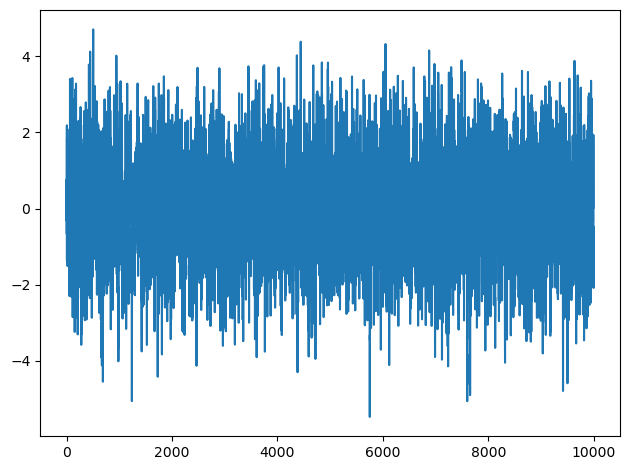

In [3]:
#Plot your simulated moving average.

plt.plot(ma4_process)
plt.tight_layout()

In [4]:
# Run the ADF test, and check if the process is stationary.

adf_result = adfuller(ma4_process)

print(f"ADF_Stat: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF_Stat: -18.539958259335272
p-value: 2.0982341466881036e-30


##### The process is stationary. It has a high negative value of adf_statistic and p value is less than 0.05.

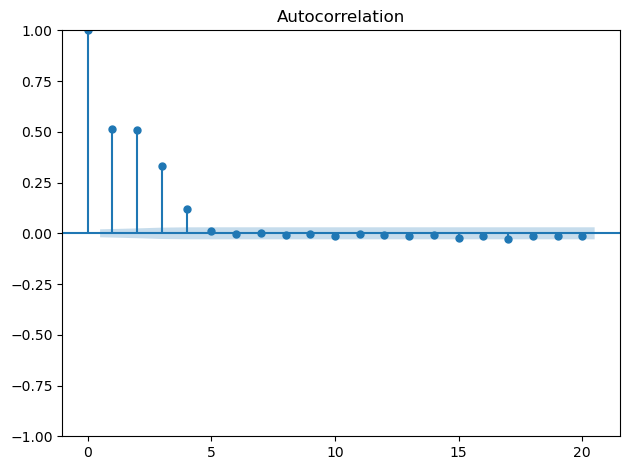

In [6]:
# Plot the ACF, and see if there are significant coefficients after lag 4.

plot_acf(ma4_process, lags=20)
plt.tight_layout()

#### There are no significant coefficients after lag4.

In [13]:
# Separate your simulated series into train and test sets. Take the first 9500 timesteps for the train set, and assign the rest to the test set.

train = ma4_process[:9500]
test = ma4_process[9500:]

In [70]:
# Make forecasts over the test set. Use the mean, last value, and an MA(4) model.
# Make sure you repeatedly forecast 4 timesteps at a time using the recursive_forecast function we defined.

In [14]:
def rolling_forecast(data: np.array, train_len: int, horizon: int, window: int, method: str)-> list:
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len,total_len,window):
            mean = np.mean(data[0:i])
            # calculate the mean for the whole train data until that index and populate it for the next window length records as forecasted value
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    if method == 'last':
        pred_last = []
        for i in range(train_len,total_len,window):
            last_value = data[:i][-1]
            pred_last.extend(last_value for _ in range(window))

        return pred_last
    
    if method == 'MA':
        pred_MA = []
        for i in range(train_len,total_len,window):
            model = SARIMAX(data[:i],order=(0,0,4))
            results = model.fit(disp = True)
            predictions = results.get_prediction(0,i+window-1)
            # get the predictions for all the data plus window size(4 in this case)
            # The last window size number of predictions are the out of sample predictions
            oos_pred = predictions.predicted_mean[-window:]
            # print(oos_pred)
            pred_MA.extend(oos_pred)
        return pred_MA
    



In [15]:
import pandas as pd
pred_df = pd.DataFrame({'value':test}, index= range(9500,10000))

# arguments for the rolling forecast function
Train_len = len(train)
Horizon = len(test)
Window = 4

pred_mean = rolling_forecast(ma4_process,Train_len,Horizon,Window,'mean')
pred_last = rolling_forecast(ma4_process,Train_len,Horizon,Window,'last')
pred_MA = rolling_forecast(ma4_process,Train_len,Horizon,Window,'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last
pred_df['pred_MA'] = pred_MA

pred_df.head()


,value,pred_mean,pred_last_value,pred_MA
9500,-1.896976,0.013895,0.407426,0.480380
9501,-1.559054,0.013895,0.407426,0.912836
9502,-4.588352,0.013895,0.407426,0.671124
9503,-2.067917,0.013895,0.407426,0.195417
9504,-1.820033,0.012826,-2.067917,-3.074976


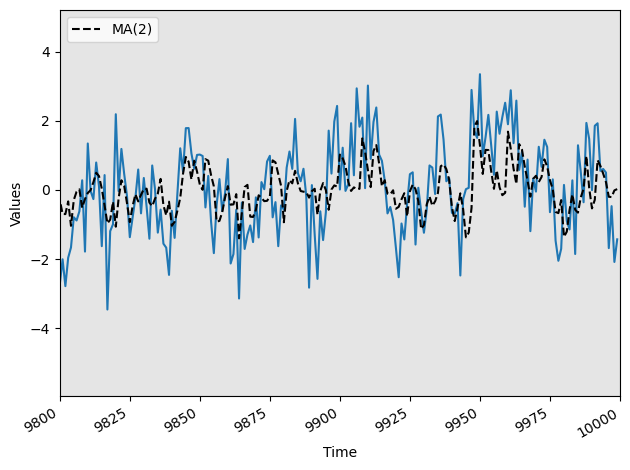

In [17]:
fig, ax = plt.subplots()

ax.plot(ma4_process)
# ax.plot(pred_df['value'], 'b-', label='actual')
# ax.plot(pred_df['pred_mean'], 'g:', label='mean')
# ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Values')

ax.axvspan(9500, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800,10000)

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['value'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

1.859772656833598 2.278547229550769 1.4545735873069898


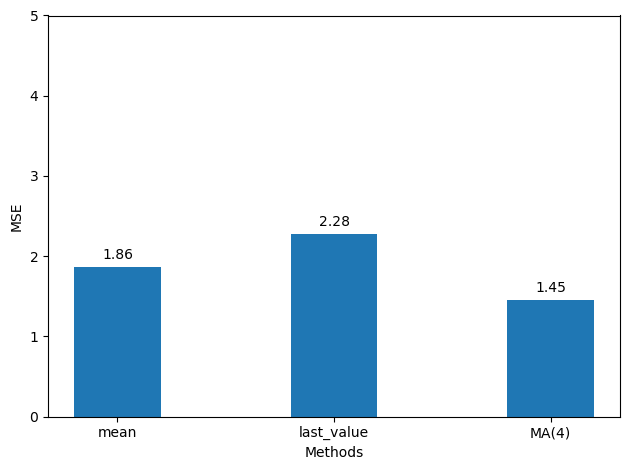

In [19]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(4)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()



MA4 model gave the least mean_squared_error, It can be considered to be the best model